I'm attempting to find some interesting TR sites from the MIMS.
We're looking at TR sites becaues they're highly polymorphic. So we should be able to more easily find TR loci with alternate alleles.

But first, lets introduce the idea of allele delta. 
Variants have a size. But variants are subject to alignment ambiguities. Even with identical alignment parameters, neighboring snps/indels can caulse differences in variant positions and sizes. However, an 'allele delta' isn't subject to the same alignment issues.

Allele delta is the length of the TR region in the reference minus the length of the haplotype that maps within the TR region.
We can calculate the allele delta by simply summing the non-snp variant lengths for each haplotype's variants within the region. For example, if a haplotype over a region has two deletions of 10bp and 20bp, the allele delta is -30bp. A single 40bp insertion would be +40bp∆.  

To keep things simple, lets find sites that have a single non-zero allele delta ≥50bp and plot the distribution of VAFs for the regions.
We want to find things with a single non-ref allele so we don't need to worry about variant representations.
Note that we'll still have some noise because +100bp∆ could be from e.g. inserting 100 As or inserting 100Ts. These different haplotypes, but we're going to compare by length for now.

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("allele_deltas.txt", sep='\t')

In [47]:
props = {"HG00438": 0.5 / 100,
         "HG002":   2 / 100,
         "HG02257": 2 / 100,
         "HG02486": 2 / 100,
         "HG02622": 10 / 100,
         "HG005":   83.5 / 100}
percents = []
for i in data.columns[3:]:
    percents.append(props[i.split('.')[0]] / 2)
percents = pd.Series(percents)    
percents
#So now you need to translate these deltas to VAF
# And then you can go MOP

0     0.0100
1     0.0100
2     0.0025
3     0.0025
4     0.4175
5     0.4175
6     0.0100
7     0.0100
8     0.0100
9     0.0100
10    0.0500
11    0.0500
dtype: float64

In [2]:
len(data), len(data) / 1_784_804

(776052, 0.43481076913767563)

In [3]:
(data['end'] - data['start']).sum()

140191485

In [5]:
has_any = data[data[data.columns[3:]] != 0].any(axis=1)
has_any.sum()

504461

In [4]:
has_50bp = data[data[data.columns[3:]].abs() >= 50].any(axis=1)
has_50bp.sum()

22047

In [6]:
only_50bp = ((data[data.columns[3:]] <= -50) | (data[data.columns[3:]] >= 50)
             | (data[data.columns[3:]] == 0)).all(axis=1)
only_50bp.sum()

280199

In [7]:
(only_50bp & has_50bp).sum()

8608

In [8]:
nunique_nonref = data[data.columns[3:]].replace(0, np.nan).nunique(axis=1)

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


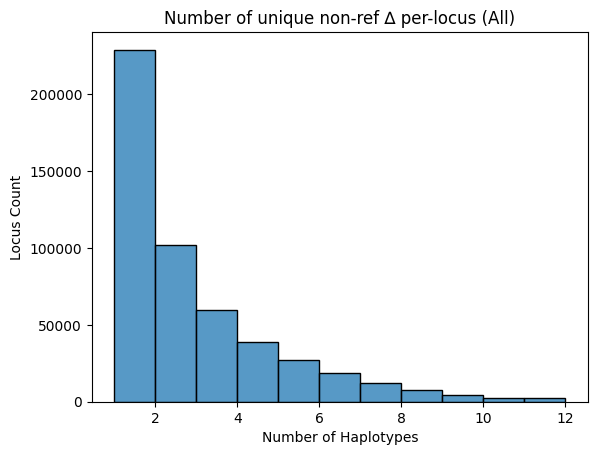

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


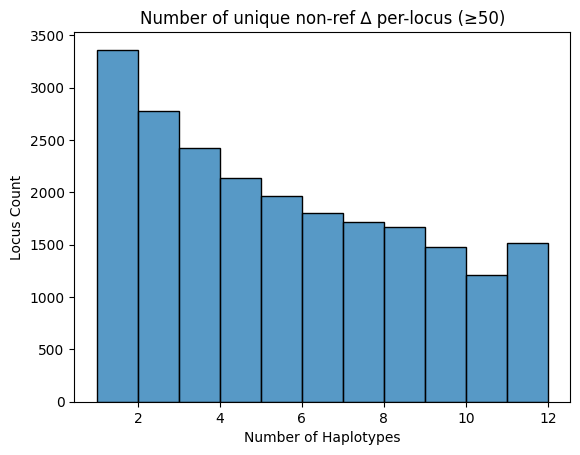

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


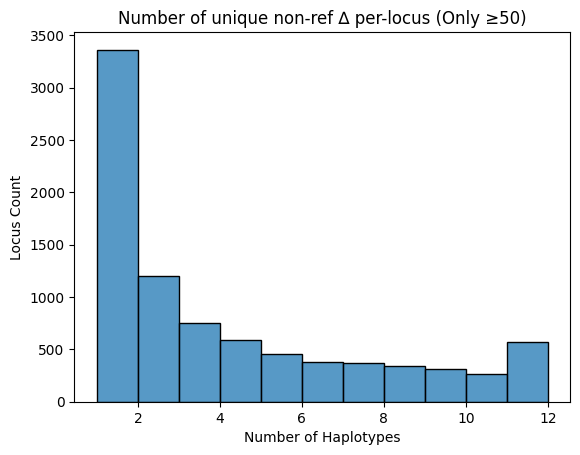

In [9]:
p = sb.histplot(nunique_nonref[nunique_nonref != 0], binwidth=1)
p.set(title="Number of unique non-ref ∆ per-locus (All)", ylabel="Locus Count", xlabel="Number of Haplotypes")
plt.show()

p = sb.histplot(nunique_nonref[(nunique_nonref != 0) & has_50bp], binwidth=1)
p.set(title="Number of unique non-ref ∆ per-locus (≥50)", ylabel="Locus Count", xlabel="Number of Haplotypes")
plt.show()

p = sb.histplot(nunique_nonref[(nunique_nonref != 0) & only_50bp & has_50bp], binwidth=1)
p.set(title="Number of unique non-ref ∆ per-locus (Only ≥50)", ylabel="Locus Count", xlabel="Number of Haplotypes")
plt.show()

In [10]:
only_1_nunique_alt = nunique_nonref[nunique_nonref==1]

In [13]:
slide5 = only_1_nunique_alt & only_50bp & has_50bp

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_2267/3295649163.py:1: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  slide5 = only_1_nunique_alt & only_50bp & has_50bp


In [29]:
import truvari

In [30]:
truvari.get_sizebin(-19)

'[15,20)'

[Text(0.5, 1.0, 'Only ∆≥50bp 1-unique sizes')]

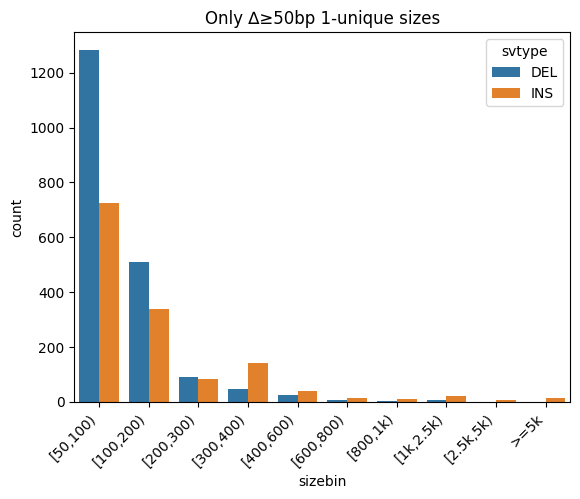

In [42]:
cnts = data[slide5][data.columns[3:]].replace(0, np.nan).mean(axis=1).astype(int).to_frame()
cnts.columns = ['size']
cnts['sizebin'] = cnts['size'].apply(truvari.get_sizebin)
cnts['svtype'] = cnts['size'].apply(lambda x: 'DEL' if x < 0 else 'INS')
p = sb.countplot(data=cnts, x="sizebin", hue="svtype", hue_order=['DEL', 'INS'], order=truvari.SZBINS[8:])
plt.xticks(rotation=45, ha='right')
p.set(title="Only ∆≥50bp 1-unique sizes")

In [43]:
cnts['svtype'].value_counts()

svtype
DEL    1968
INS    1393
Name: count, dtype: int64

In [15]:
# Number of samples the single alt is in:
(data[slide5][data.columns[3:]] != 0).sum(axis=1).value_counts()

1     1244
2      516
3      293
4      241
5      201
12     175
6      159
7      144
8      116
9      102
10      95
11      75
Name: count, dtype: int64

In [58]:
view = data[slide5].copy()

In [59]:
vaf = ((view[data.columns[3:]] != 0) * percents.values).sum(axis=1)

In [60]:
view['VAF'] = vaf

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


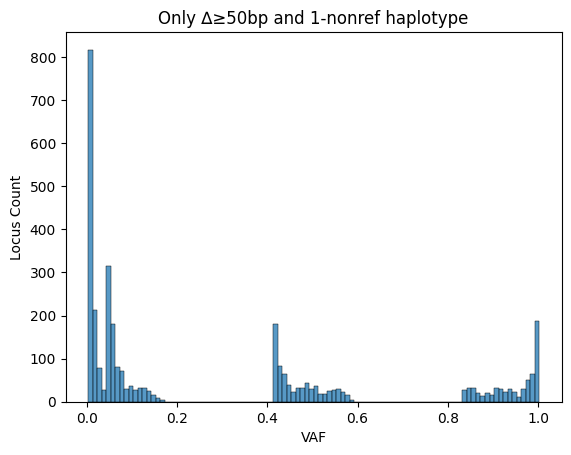

In [54]:
p = sb.histplot(vaf, binwidth=0.01)
_ = p.set(title="Only ∆≥50bp and 1-nonref haplotype", xlabel="VAF", ylabel="Locus Count")

In [61]:
not_between = ~vaf.between(0.25, 0.75)
not_between.sum()

2634

In [63]:
view[not_between][['chrom', 'start', 'end', 'VAF']].to_csv("single.delta50.bed", sep='\t', index=False, header=False)

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Unique allele deltas per-TR'),
 Text(0.5, 0, 'Num Haplotypes'),
 Text(0, 0.5, 'TR Count')]

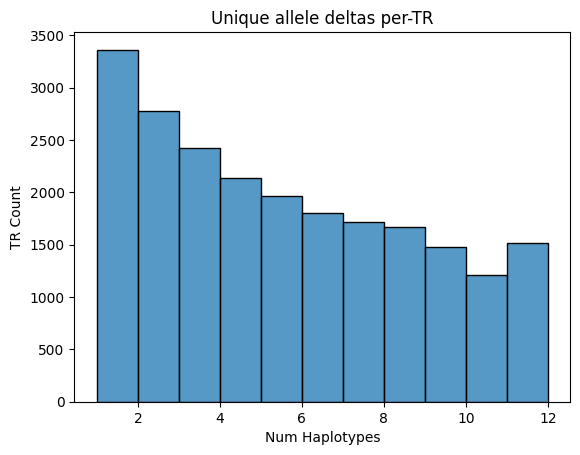

In [114]:
p = sb.histplot(nunique_nonref[(nunique_nonref != 0) & has_50bp], binwidth=1)
p.set(title="Unique allele deltas per-TR", xlabel="Num Haplotypes", ylabel="TR Count")

In [125]:
len(nunique_nonref[(nunique_nonref != 0) & only_50bp])

8608

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


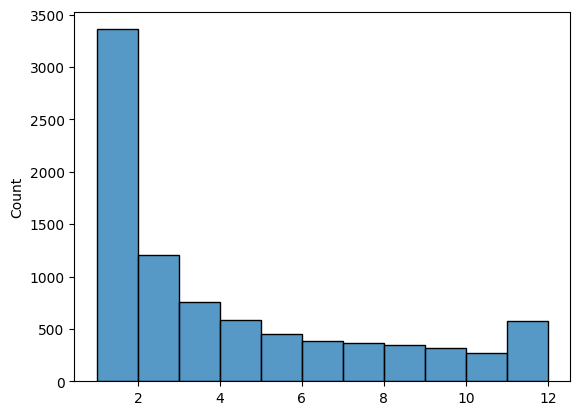

In [126]:
# at least one non-ref delta. all 
p = sb.histplot(nunique_nonref[(nunique_nonref != 0) & only_50bp], binwidth=1)


In [83]:
mean = data[data.columns[3:]].mean(axis=1)
std = data[data.columns[3:]].std(axis=1)
nunique = data[data.columns[3:]].nunique(axis=1)

any_at_least_10 = (data[data.columns[3:]].abs() >= 10).any(axis=1)
all_at_least_10 = (data[data.columns[3:]].abs() >= 10).all(axis=1)
any_at_least_50 = (data[data.columns[3:]].abs() >= 50).any(axis=1)
all_at_least_50 = (data[data.columns[3:]].abs() >= 50).all(axis=1)

all_at_least_10_excluderef = ((data[data.columns[3:]].abs() >= 10) | (data[data.columns[3:]].abs() == 0)).all(axis=1)
all_at_least_50_excluderef = ((data[data.columns[3:]].abs() >= 50) | (data[data.columns[3:]].abs() == 0)).all(axis=1)

#https://en.wikipedia.org/wiki/Coefficient_of_variation
coeff_of_var = std / mean

In [84]:
len(data)

776052

In [85]:
print('any 10', any_at_least_10.sum())
print('all 10', all_at_least_10.sum())
print('all 10 !ref', all_at_least_10_excluderef.sum())
print('any 50', any_at_least_50.sum())
print('all 50', all_at_least_50.sum())
print('all 50 !ref', all_at_least_50_excluderef.sum())

any 10 132491
all 10 7229
all 10 !ref 308324
any 50 22047
all 50 3212
all 50 !ref 280199


/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


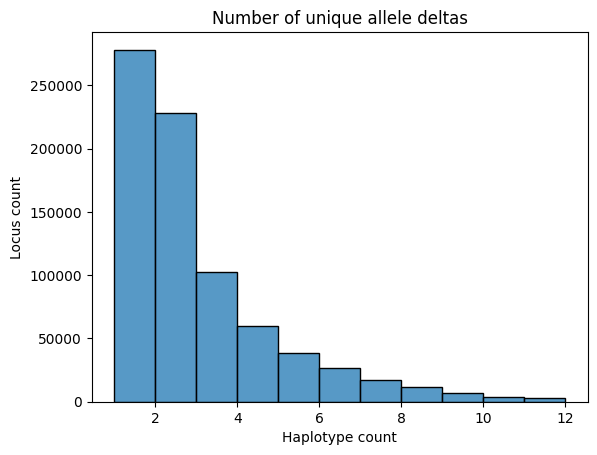

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


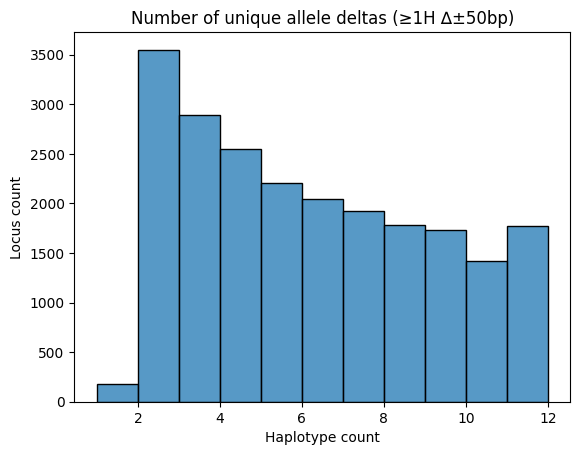

In [87]:
p = sb.histplot(nunique, binwidth=1)
p.set(title="Number of unique allele deltas", ylabel="Locus count", xlabel="Haplotype count")
plt.show()
p = sb.histplot(nunique[any_at_least_50], binwidth=1)
p.set(title="Number of unique allele deltas (≥1H ∆±50bp)", ylabel="Locus count", xlabel="Haplotype count")
plt.show()

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

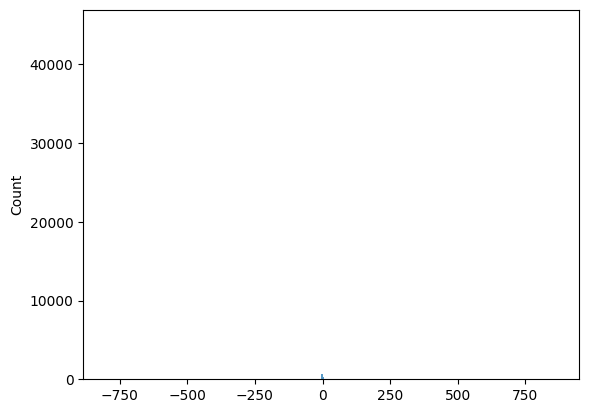

In [88]:
sb.histplot(coeff_of_var)

In [13]:
(nunique[at_least_10].value_counts() / at_least_10.sum()).sort_index()

1     0.006116
2     0.149940
3     0.135020
4     0.170605
5     0.175146
6     0.142434
7     0.089148
8     0.057641
9     0.036049
10    0.021963
11    0.011676
12    0.004263
Name: count, dtype: float64

In [35]:
data[data.columns[3:]].head() * percents.values

,HG002.1,HG002.2,HG00438.1,HG00438.2,HG005.1,HG005.2,HG02257.1,HG02257.2,HG02486.1,HG02486.2,HG02622.1,HG02622.2
0,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0
1,0.00,0.00,0.0000,0.0000,0.4175,0.0000,0.00,0.00,0.00,0.00,0.00,0.0
2,0.07,0.07,0.0175,0.0175,2.9225,2.9225,0.07,0.07,0.07,0.07,0.35,4.5
3,0.50,0.50,0.1250,0.1250,20.8750,20.8750,0.50,0.50,0.50,0.50,4.85,2.5
4,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0


0     0.0100
1     0.0100
2     0.0025
3     0.0025
4     0.4175
5     0.4175
6     0.0100
7     0.0100
8     0.0100
9     0.0100
10    0.0500
11    0.0500
dtype: float64

In [36]:
by_len_vaf = []
for idx, row in data.iterrows():
    unique_by_length = row[data.columns[3:]].unique()
    m_vaf = 0
    for i in unique_by_length:
        len_vaf = ((row[data.columns[3:]] == i) * percents.values).sum() 
        by_len_vaf.append((idx, i, len_vaf))
by_len_vaf = pd.DataFrame(by_len_vaf, columns=["index", "length", "vaf"])
by_len_vaf.set_index('index', inplace=True)

In [37]:
by_len_vaf

,length,vaf
index,,
0,0,1.0000
1,0,0.5825
1,1,0.4175
2,7,0.9500
2,90,0.0500
...,...,...
63275,279,0.0200
63275,372,0.0025
63275,283,0.0100


In [38]:
data.head()

,chrom,start,end,HG002.1,HG002.2,HG00438.1,HG00438.2,HG005.1,HG005.2,HG02257.1,HG02257.2,HG02486.1,HG02486.2,HG02622.1,HG02622.2
0,chr1,689941,690073,0,0,0,0,0,0,0,0,0,0,0,0
1,chr1,691047,691100,0,0,0,0,1,0,0,0,0,0,0,0
2,chr1,711932,712118,7,7,7,7,7,7,7,7,7,7,7,90
3,chr1,714241,714517,50,50,50,50,50,50,50,50,50,50,97,50
4,chr1,724685,724841,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
by_len_vaf.loc[3]

,length,vaf
index,,
3,50,0.95
3,97,0.05


In [48]:
first_set = data[at_least_10 & (nunique > 2)]

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='vaf', ylabel='Count'>

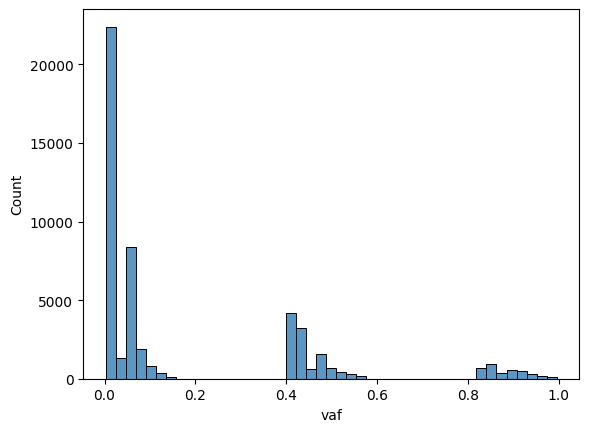

In [49]:
sb.histplot(data=by_len_vaf.loc[first_set.index], x="vaf")

In [51]:
data.loc[9]

chrom          chr1
start        744841
end          744921
HG002.1          16
HG002.2          18
HG00438.1        50
HG00438.2        40
HG005.1          24
HG005.2          24
HG02257.1        28
HG02257.2        32
HG02486.1        26
HG02486.2        22
HG02622.1        12
HG02622.2         4
Name: 9, dtype: object

In [50]:
by_len_vaf.loc[first_set.index]

,length,vaf
9,16,0.0100
9,18,0.0100
9,50,0.0025
9,40,0.0025
9,24,0.8350
...,...,...
63273,10,0.0100
63275,93,0.9675
63275,279,0.0200
63275,372,0.0025


In [53]:
at_least_50 = (data[data.columns[3:]] >= 50).any(axis=1)
second_set = data[at_least_50 & (nunique > 2)]

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='vaf', ylabel='Count'>

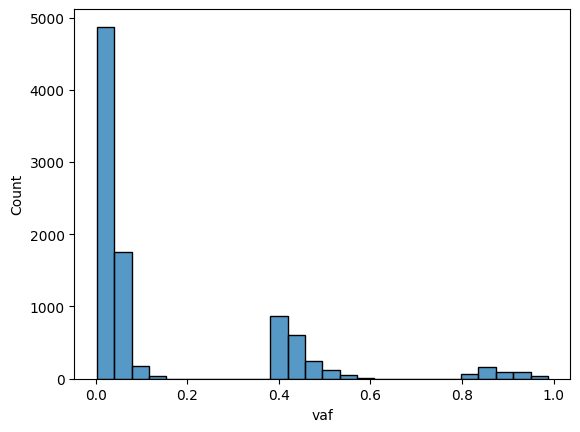

In [54]:
sb.histplot(data=by_len_vaf.loc[second_set.index], x="vaf")

In [55]:
view = by_len_vaf.loc[second_set.index]

In [58]:
view.sample(5)

,length,vaf
50344,68,0.4175
11868,140,0.4200
16414,50,0.0600
32183,2435,0.0100
61872,115,0.0500


In [59]:
data.loc[50344]

chrom             chr1
start        205906434
end          205906609
HG002.1             82
HG002.2              0
HG00438.1           48
HG00438.2           48
HG005.1             52
HG005.2             68
HG02257.1            6
HG02257.2            8
HG02486.1           60
HG02486.2            0
HG02622.1           52
HG02622.2           56
Name: 50344, dtype: object

0          0.000000
1          0.288675
2         23.960036
3         13.567731
4          0.000000
            ...    
63272      0.000000
63273      3.128559
63274      0.000000
63275    106.255659
63276      0.577350
Length: 63277, dtype: float64

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

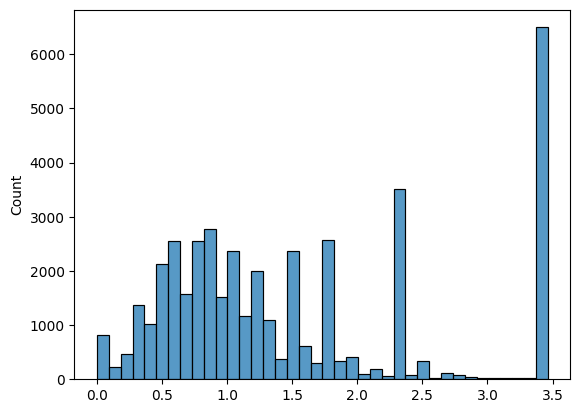

In [62]:
sb.histplot(coeff_of_var)